# Notebook for Embedding the cleaned and preprocessed tweets

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec

In [3]:
with open('../data/tweets_tokenized.pickle', 'rb') as f:
    tweets_tokenized = pickle.load(f)
    
with open('../data/tweets_preprocessed.pickle', 'rb') as f:
    tweets = pickle.load(f)

## Training the W2V Model

- What are the hyperparameters?
- Which methods are used
- How is it trained?

Word2Vec takes a text corpus as an input and produces word vectors as output.
- First constructs a vocabulary from the training data
- Learns vector representation of words
- Word vectors can be used for deriving word classes by performing k-means clustering on top of the word vectors 

Inputs for ```Word2Vec```
- Sentences = Our tweets, in this case just a list
- Sg: Defines the trainig algorithm 0: CBOW, 1:Skip-gram
- Size: Dimensionality of the feature vector
- Window: Maximum distance between current and predicted word within sentence
- alpha: Initial learning rate
- min_count: Ignore all words with total frequency lower than this
- workers: Use this many workers to train the model
- hs: If 1, hierarchical softmax will be used for model training, 0: and negative is non-zero, negative sampling will be used
- negative:  if >0, negative sampling will be used, the integer specifies how many "noise words" should be drawn (usually between 5-20, default 5)
- cbow_mean: If 0, use the sum of the context word vectors  
- iter: Number of iterations over the corpus, default is 5
- trim_rule: Vocab trimming rule
- sorted_vocab: if 1 (default) sort the vocab by descending frequency before assigning word indexes
- batch_words: target size (in words) for batches of examples passed to worker threads

Inputs for ```Word2Vec.train()```


- training is done on the list of list where each entry is a tokenized tweet
- Train builds the vocabulary and trains the word2vec model

How does it work?
- Train a neural network with a hidden single layer where the goal is to predict the current word based on the context
- The goal is to learn the weights of the hidden layer, which are essentially the word vectors we're trying to learn

After training, we can discard the full model state and work just with the vectors.

### Hyperparameters very hard to decide for us since we want it for unsupervised learning


Let's see how many unique words we have:


In [4]:
from collections import defaultdict

In [5]:
word_freq = defaultdict(int)
for t in tweets_tokenized:
    for w in t:
        word_freq[w] += 1
len(word_freq)


250128

So we have 250.128 unique words in total.

### Detecting Phrases

First we automatically detect phrases like Donald Trump or Hillary Clinton using gensims Phrases model.

In [4]:
# Import model
from gensim.models.phrases import Phrases, Phraser

In [5]:
# train
phrases = Phrases(tweets_tokenized, min_count=30, progress_per=10000)

In [6]:
# Make bigrams
bigram = Phraser(phrases)

In [7]:
# Making the corpus
tweets_clean =  bigram[tweets_tokenized]

### W2V Model

In [8]:
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [9]:
# CBOW model, without building vocabulary yet
w2v_model = Word2Vec(size=100, 
                 alpha = 0.025,
                 window=8, 
                 sg = 0,
                 min_count=20,
                 sample = 6e-5,
                 workers=8,
                 negative = 5,
                 iter = 5)

In [10]:
# Building the vocabulary
w2v_model.build_vocab(tweets_clean, progress_per=500000)

INFO - 21:52:45: collecting all words and their counts
INFO - 21:52:45: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 21:53:03: PROGRESS: at sentence #500000, processed 5309915 words, keeping 122437 word types
INFO - 21:53:22: PROGRESS: at sentence #1000000, processed 10589256 words, keeping 169340 word types
INFO - 21:53:41: PROGRESS: at sentence #1500000, processed 15871687 words, keeping 204813 word types
INFO - 21:53:59: PROGRESS: at sentence #2000000, processed 21151579 words, keeping 234194 word types
INFO - 21:54:18: PROGRESS: at sentence #2500000, processed 26427126 words, keeping 260462 word types
INFO - 21:54:19: collected 262327 word types from a corpus of 26810472 raw words and 2536417 sentences
INFO - 21:54:19: Loading a fresh vocabulary
INFO - 21:54:20: effective_min_count=20 retains 47256 unique words (18% of original 262327, drops 215071)
INFO - 21:54:20: effective_min_count=20 leaves 26180234 word corpus (97% of original 26810472, drops 63023

- Downsampling deletes quite a lot!
- Hyperparameter tuning for vocab will be needed at some point.

In [27]:
# Training the model
w2v_model.train(tweets_tokenized, total_examples=w2v_model.corpus_count, epochs=5, report_delay=1)

INFO - 13:06:23: training model with 8 workers on 47256 vocabulary and 100 features, using sg=0 hs=0 sample=6e-05 negative=5 window=8
INFO - 13:06:24: EPOCH 1 - PROGRESS: at 4.21% examples, 648884 words/s, in_qsize 13, out_qsize 2
INFO - 13:06:25: EPOCH 1 - PROGRESS: at 8.59% examples, 664236 words/s, in_qsize 16, out_qsize 1
INFO - 13:06:26: EPOCH 1 - PROGRESS: at 12.16% examples, 629197 words/s, in_qsize 15, out_qsize 0
INFO - 13:06:27: EPOCH 1 - PROGRESS: at 16.69% examples, 648439 words/s, in_qsize 16, out_qsize 2
INFO - 13:06:28: EPOCH 1 - PROGRESS: at 21.27% examples, 662654 words/s, in_qsize 15, out_qsize 0
INFO - 13:06:29: EPOCH 1 - PROGRESS: at 25.67% examples, 666622 words/s, in_qsize 15, out_qsize 0
INFO - 13:06:30: EPOCH 1 - PROGRESS: at 30.18% examples, 672122 words/s, in_qsize 16, out_qsize 0
INFO - 13:06:31: EPOCH 1 - PROGRESS: at 33.92% examples, 661217 words/s, in_qsize 16, out_qsize 2
INFO - 13:06:32: EPOCH 1 - PROGRESS: at 38.40% examples, 664808 words/s, in_qsize 14

INFO - 13:07:33: EPOCH 3 - PROGRESS: at 82.00% examples, 606012 words/s, in_qsize 15, out_qsize 0
INFO - 13:07:34: EPOCH 3 - PROGRESS: at 85.88% examples, 606065 words/s, in_qsize 15, out_qsize 0
INFO - 13:07:35: EPOCH 3 - PROGRESS: at 89.45% examples, 603989 words/s, in_qsize 15, out_qsize 0
INFO - 13:07:36: EPOCH 3 - PROGRESS: at 92.88% examples, 601221 words/s, in_qsize 14, out_qsize 1
INFO - 13:07:37: EPOCH 3 - PROGRESS: at 96.60% examples, 600290 words/s, in_qsize 16, out_qsize 0
INFO - 13:07:38: worker thread finished; awaiting finish of 7 more threads
INFO - 13:07:38: worker thread finished; awaiting finish of 6 more threads
INFO - 13:07:38: worker thread finished; awaiting finish of 5 more threads
INFO - 13:07:38: worker thread finished; awaiting finish of 4 more threads
INFO - 13:07:38: worker thread finished; awaiting finish of 3 more threads
INFO - 13:07:38: worker thread finished; awaiting finish of 2 more threads
INFO - 13:07:38: worker thread finished; awaiting finish of 

(78495137, 144404730)

In [12]:
# Storing results
w2v_model.init_sims(replace=True)

INFO - 09:12:28: precomputing L2-norms of word weight vectors


In [ ]:
w2v_model

In [16]:
# Save the model
w2v_model.save("../models/w2v_model1.model")

INFO - 09:15:19: saving Word2Vec object under ../models/w2v_model1.model, separately None
INFO - 09:15:19: not storing attribute vectors_norm
INFO - 09:15:19: not storing attribute cum_table
WARNING - 09:15:19: this function is deprecated, use smart_open.open instead
INFO - 09:15:19: saved ../models/w2v_model1.model


### Exploring model outputs

In [29]:
w2v_model.wv.most_similar(positive=["trump"])

[('donald', 0.7785766124725342),
 ('trumps', 0.7442030906677246),
 ('obama', 0.7382049560546875),
 ('donaldtrump', 0.7302083969116211),
 ('priebus', 0.7068217992782593),
 ('pres', 0.7034913897514343),
 ('rnc', 0.6844936013221741),
 ('newt', 0.6839495897293091),
 ('feedly', 0.6823227405548096),
 ('clinton', 0.6726359128952026)]

In [96]:
w2v_model.wv.most_similar(positive=["hillary"])

[('pneumonia', 0.46842673420906067),
 ('hillaryshealth', 0.4445585012435913),
 ('releaseclintonsmedicalrecords', 0.43610680103302),
 ('hillaryemail', 0.43239855766296387),
 ('rodham', 0.42621496319770813),
 ('neverhillary', 0.4208459258079529),
 ('benghazi', 0.4199448525905609),
 ('imnotwithher', 0.41990166902542114),
 ('spiritcooking', 0.4189653992652893),
 ('33k', 0.4181525707244873)]

In [31]:
w2v_model.wv.most_similar(positive=["sanders"], [])

[('berniesanders', 0.634432852268219),
 ('fiorina', 0.6195588111877441),
 ('bernie', 0.6123321056365967),
 ('clinton', 0.5989682674407959),
 ('rnc', 0.5865535736083984),
 ('nh', 0.5761868953704834),
 ('madoff', 0.5739449262619019),
 ('gop', 0.567136287689209),
 ('hillary', 0.5536671280860901),
 ('delegates', 0.5491266846656799)]

In [32]:
w2v_model.wv.most_similar(positive=["russia"])

[('putin', 0.8355970978736877),
 ('russian', 0.8171623945236206),
 ('kremlin', 0.8147741556167603),
 ('russians', 0.790194034576416),
 ('interference', 0.7377739548683167),
 ('trumprussia', 0.7307552099227905),
 ('collusion', 0.7129173278808594),
 ('nato', 0.7046849727630615),
 ('rus', 0.6939290761947632),
 ('colluded', 0.6925141215324402)]

In [33]:
w2v_model.wv.most_similar(positive=["rnc"])

[('campaign', 0.7073675394058228),
 ('gop', 0.7022981643676758),
 ('priebus', 0.6958321332931519),
 ('aides', 0.6957103610038757),
 ('moderator', 0.6866159439086914),
 ('trump', 0.6844936609268188),
 ('conway', 0.678608238697052),
 ('dnc', 0.6776957511901855),
 ('gopers', 0.6748570203781128),
 ('romney', 0.6612654328346252)]

In [35]:
w2v_model.wv.most_similar(positive=["democratic"])

[('republican', 0.8081129789352417),
 ('dem', 0.791176974773407),
 ('democrat', 0.7697725296020508),
 ('gop', 0.7615995407104492),
 ('establishment', 0.7002128958702087),
 ('democrats', 0.6927468776702881),
 ('dnc', 0.6903260350227356),
 ('dems', 0.6669731140136719),
 ('primary', 0.649936318397522),
 ('primaries', 0.64875328540802)]

In [36]:
w2v_model.wv.most_similar(positive=["republican"])

[('gop', 0.8716017007827759),
 ('democratic', 0.8081130385398865),
 ('democrat', 0.7854833602905273),
 ('dem', 0.744016170501709),
 ('republicans', 0.7152346968650818),
 ('democrats', 0.6772005558013916),
 ('establishment', 0.6693316698074341),
 ('candidate', 0.6606999635696411),
 ('congressional', 0.6589505672454834),
 ('rnc', 0.6561763286590576)]

In [38]:
w2v_model.wv.most_similar(positive=["black"])

[('blacktolive', 0.7278733849525452),
 ('blm', 0.7191097736358643),
 ('poc', 0.7013176679611206),
 ('white', 0.7004172801971436),
 ('whites', 0.6812653541564941),
 ('blk', 0.6780024766921997),
 ('blackhistory', 0.6557381749153137),
 ('blacks', 0.6486348509788513),
 ('amerikkka', 0.6457083821296692),
 ('color', 0.6396654844284058)]

In [39]:
w2v_model.wv.most_similar(positive=["conservative"])

[('conservatives', 0.729949414730072),
 ('progressive', 0.7124125361442566),
 ('establishment', 0.676652193069458),
 ('evangelicals', 0.6479054689407349),
 ('principled', 0.638511061668396),
 ('liberal', 0.635835587978363),
 ('evangelical', 0.6323487758636475),
 ('grassroots', 0.6301127076148987),
 ('populist', 0.6282006502151489),
 ('republican', 0.6278011798858643)]

In [40]:
w2v_model.wv.most_similar(positive=["liberals"])

[('libs', 0.8686085939407349),
 ('leftists', 0.8567847013473511),
 ('libtards', 0.8410685062408447),
 ('democrats', 0.7540494799613953),
 ('progressives', 0.7526166439056396),
 ('fascists', 0.7496113181114197),
 ('liberal', 0.7484761476516724),
 ('hypocrites', 0.7453405857086182),
 ('conservatives', 0.7419589757919312),
 ('bigots', 0.738998532295227)]

In [41]:
w2v_model.wv.most_similar(positive=["conservatives"])

[('progressives', 0.8131051659584045),
 ('democrats', 0.7801730632781982),
 ('republicans', 0.7753037810325623),
 ('liberals', 0.7419589757919312),
 ('conservative', 0.7299492955207825),
 ('libs', 0.7291273474693298),
 ('dems', 0.7253261804580688),
 ('establishment', 0.7159870862960815),
 ('leftists', 0.6896424293518066),
 ('evangelicals', 0.6886000633239746)]

In [42]:
w2v_model.wv.most_similar(positive=["nato"])

[('envoy', 0.7853487730026245),
 ('diplomatic', 0.7753986120223999),
 ('nohkorea', 0.7660033106803894),
 ('saudiarabia', 0.7637949585914612),
 ('cooperation', 0.754379391670227),
 ('syria', 0.7493931651115417),
 ('erdogan', 0.7349990010261536),
 ('assad', 0.7293091416358948),
 ('unsc', 0.7237667441368103),
 ('alliance', 0.7218502163887024)]

In [43]:
w2v_model.wv.most_similar(positive=["isis"])

[('jihadists', 0.8073362708091736),
 ('isil', 0.7990605235099792),
 ('terrorists', 0.7559356689453125),
 ('alqaeda', 0.7509000897407532),
 ('raqqa', 0.7407999038696289),
 ('iraqi', 0.7393286824226379),
 ('kurds', 0.7310911417007446),
 ('islamic', 0.728545069694519),
 ('islamicstate', 0.7257480621337891),
 ('assad', 0.7253738641738892)]

In [44]:
w2v_model.wv.most_similar(positive=["islam"])

[('christianity', 0.8456521034240723),
 ('jihad', 0.7973436117172241),
 ('muslims', 0.7781784534454346),
 ('islamism', 0.7724980711936951),
 ('sharialaw', 0.7674444913864136),
 ('sharia', 0.7671754360198975),
 ('religionofpeace', 0.7583584189414978),
 ('islamistheproblem', 0.7547909021377563),
 ('shariah', 0.7482728958129883),
 ('islamist', 0.744233250617981)]

In [45]:
w2v_model.wv.most_similar(positive=["christian"])

[('atheist', 0.7836394309997559),
 ('christianity', 0.7021538019180298),
 ('catholic', 0.6701041460037231),
 ('christians', 0.6698487997055054),
 ('evangelical', 0.663507342338562),
 ('judeo', 0.6441650986671448),
 ('bakers', 0.6414981484413147),
 ('islam', 0.6412274241447449),
 ('catholics', 0.6264002919197083),
 ('quran', 0.6219053864479065)]

In [46]:
w2v_model.wv.most_similar(positive=["swamp"])

[('draining', 0.8321763277053833),
 ('drain', 0.7186734080314636),
 ('draintheswamp', 0.6750122308731079),
 ('whitehouse', 0.6044195890426636),
 ('dts', 0.5912712812423706),
 ('masa', 0.5893805027008057),
 ('maga3x', 0.5863811373710632),
 ('leakers', 0.5835847854614258),
 ('potus', 0.5718278884887695),
 ('establishment', 0.5636913776397705)]

In [47]:
w2v_model.wv.most_similar(positive=["maga"])

[('trumptrain', 0.8809293508529663),
 ('trumpsarmy', 0.8596439361572266),
 ('maga3x', 0.8513104915618896),
 ('trum', 0.8457320928573608),
 ('trump45', 0.8426646590232849),
 ('presidenttrump', 0.84065842628479),
 ('tr', 0.8358815908432007),
 ('trumpt', 0.8333978652954102),
 ('hesmypresident', 0.832449197769165),
 ('trumpstrong', 0.8321759104728699)]

In [48]:
w2v_model.wv.most_similar(positive=["rigged"])

[('rigging', 0.7601094245910645),
 ('election2016', 0.7066903114318848),
 ('dncleak', 0.6892914772033691),
 ('voterfraud', 0.6862283945083618),
 ('russianhackers', 0.685019850730896),
 ('pollsters', 0.6521154642105103),
 ('electoralcollege', 0.6491137742996216),
 ('hrc', 0.6455065011978149),
 ('dropouthillary', 0.6427524089813232),
 ('primaries', 0.6390612721443176)]

In [50]:
w2v_model.wv.most_similar(positive=["lgbt"])

[('lgbtq', 0.805208683013916),
 ('indianafedup', 0.7633690237998962),
 ('indianalaw', 0.7291101217269897),
 ('prayforgay', 0.7250359058380127),
 ('trans', 0.681766152381897),
 ('gaypride', 0.6696629524230957),
 ('boycottindiana', 0.6682590246200562),
 ('discrimination', 0.6579451560974121),
 ('homosexuals', 0.6505677700042725),
 ('gay', 0.6475652456283569)]

In [55]:
w2v_model.wv.most_similar(positive=["news"])

[('local', 0.8312311172485352),
 ('stlouis', 0.7147109508514404),
 ('nky', 0.664106011390686),
 ('evanston', 0.657109797000885),
 ('chicago', 0.6531118750572205),
 ('naperville', 0.6496122479438782),
 ('bellevue', 0.6454225778579712),
 ('milwaukee', 0.640254020690918),
 ('frisco', 0.6402102708816528),
 ('grapevine', 0.6266241073608398)]

In [104]:
w2v_model.wv.most_similar(positive=["hillary", "candidate"], negative=["women"])

[('hillaryclinton', 0.6432985067367554),
 ('prez', 0.6374080181121826),
 ('hrc', 0.6165152788162231),
 ('clinton', 0.6157883405685425),
 ('democrat', 0.6085970401763916),
 ('dncleak', 0.605018675327301),
 ('brazile', 0.6040425300598145),
 ('pollster', 0.6015428304672241),
 ('dncchair', 0.5984686017036438),
 ('crookedhillary', 0.5952076315879822)]

In [61]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [81]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    
    arrays_dim = w2v_model.wv.__getitem__([word]).shape[1]
    arrays = np.empty((0, arrays_dim), dtype='f')
    word_labels = [word]
    color_list  = ['red']
    
    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=10).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

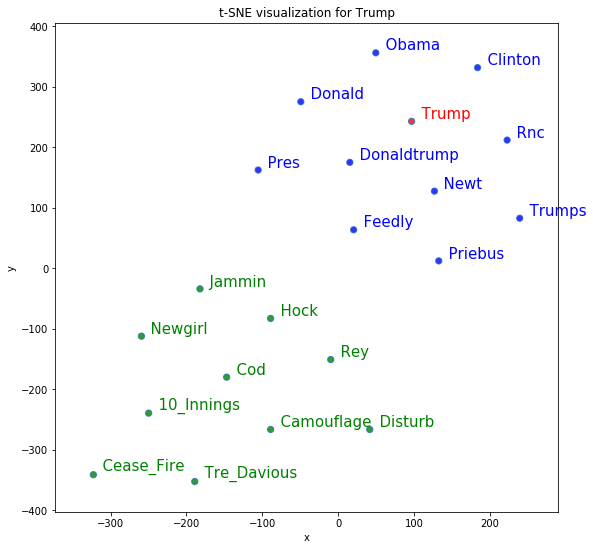

In [131]:
tsnescatterplot(w2v_model, 'trump', [i[0] for i in w2v_model.wv.most_similar(negative=["clinton"])])

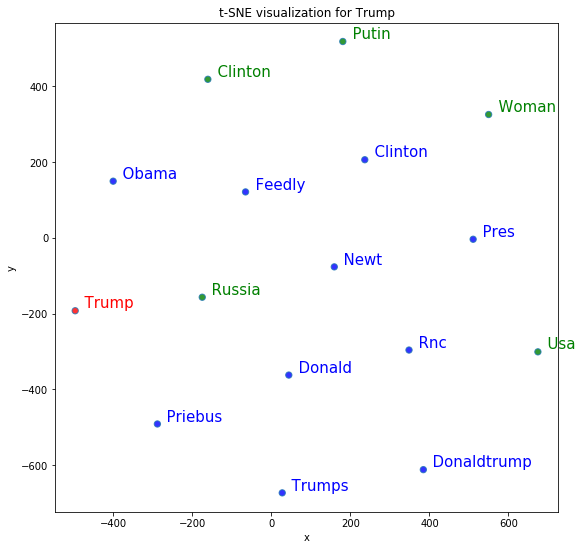

In [85]:
tsnescatterplot(w2v_model, 'trump',["clinton","woman","russia","usa", "putin"])

INFO - 22:12:24: saving Word2VecKeyedVectors object under ../models/w2v_model1,model, separately None
INFO - 22:12:24: not storing attribute vectors_norm
WARNING - 22:12:24: this function is deprecated, use smart_open.open instead
INFO - 22:12:25: saved ../models/w2v_model1,model


In [8]:
# Cluster
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, max_iter=1000).fit(w2v_matrix)

In [9]:
labels = np.array(kmeans.predict(w2v_matrix))

In [16]:
cluster1 = tweets[labels==0]
cluster2 = tweets[labels==1]

In [21]:
from utils.wordcloud import plot_wordcloud

In [24]:
cluster1 = [tweet for tweet in cluster1]
cluster2 = [tweet for tweet in cluster2]

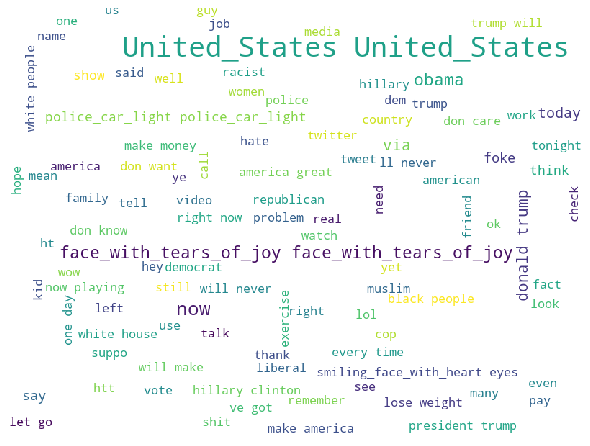

In [25]:
plot_wordcloud(cluster1)

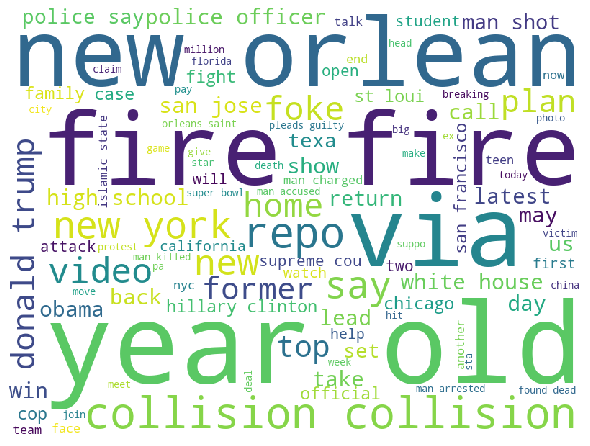

In [26]:
plot_wordcloud(cluster2)

In [29]:
from sklearn.metrics import pairwise_distances_argmin_min
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, w2v_matrix)

In [34]:
from sklearn.metrics.pairwise import cosine_similarity

In [53]:
np.sum(labels ==1)

1106455

In [54]:
np.sum(labels == 0)

1655254

In [55]:
cosine_similarity(w2v_matrix[labels == 0,], w2v_matrix[labels == 1,])

MemoryError: 

In [30]:
closest

array([1592212, 2276660])

In [31]:
tweets[1592212]

['that',
 'is',
 'what',
 'really',
 'impoant',
 'for',
 'me',
 'and',
 'my',
 'country',
 'and',
 'none',
 'of',
 'the',
 'liberals',
 'can',
 'take',
 'it',
 'away']

In [32]:
tweets[2276660]

['man',
 'accused',
 'of',
 'igniting',
 'wild',
 'brawl',
 'on',
 'seattle',
 'to',
 'beijing',
 'flight',
 'to',
 'remain',
 'in',
 'federal',
 'custody']